In [ ]:

import kagglehub
emrehakanerdemir_face_deblurring_dataset_using_celeba_path = kagglehub.dataset_download('emrehakanerdemir/face-deblurring-dataset-using-celeba')

print('Data source import complete.')


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from pytorch_msssim import ssim
import torch.nn.functional as F
from torchmetrics.functional import structural_similarity_index_measure as ssim_fn
import random

In [ ]:

X_TRAIN_DIR = "/kaggle/input/face-deblurring-dataset-using-celeba/input/train"
X_TEST_DIR = "/kaggle/input/face-deblurring-dataset-using-celeba/input/test"
X_VAL_DIR = "/kaggle/input/face-deblurring-dataset-using-celeba/input/val"

y_TRAIN_DIR = "/kaggle/input/face-deblurring-dataset-using-celeba/output/train"
y_TEST_DIR = "/kaggle/input/face-deblurring-dataset-using-celeba/output/test"
y_VAL_DIR = "/kaggle/input/face-deblurring-dataset-using-celeba/output/val"

TRAIN_BATCH_SIZE = 16
TEST_VAL_BATCH_SIZE = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
if device == "cuda":
    torch.backends.cudnn.benchmark = True


In [ ]:
class CelebaDatasetM(Dataset):
    def __init__(self,input_dir,transform=None):
        super().__init__()
        self.input_dir = input_dir
        self.input_images = os.listdir(self.input_dir)
        self.transform = transform
    def __len__(self):
        return len(self.input_images)
    def __getitem__(self,idx):
        X = os.path.join(self.input_dir, self.input_images[idx])
        X = Image.open(X)
        if self.transform:
            X = self.transform(X)
        return X

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128))
])



In [ ]:
train_dataset = CelebaDatasetM(y_TRAIN_DIR,transform=transform)
test_dataset = CelebaDatasetM(y_TEST_DIR,transform=transform)
val_dataset = CelebaDatasetM(y_VAL_DIR,transform=transform)

train_dataloader = DataLoader(train_dataset,batch_size=TRAIN_BATCH_SIZE,shuffle=True, num_workers=4,
    pin_memory=True,
    persistent_workers=True)
test_dataloader = DataLoader(test_dataset,batch_size=TEST_VAL_BATCH_SIZE,shuffle=True, num_workers=4,
    pin_memory=True,
    persistent_workers=True)
val_dataloader = DataLoader(val_dataset,batch_size=TEST_VAL_BATCH_SIZE,shuffle=True, num_workers=4,
    pin_memory=True,
    persistent_workers=True)


In [ ]:
type(train_dataset[0])

torch.Tensor

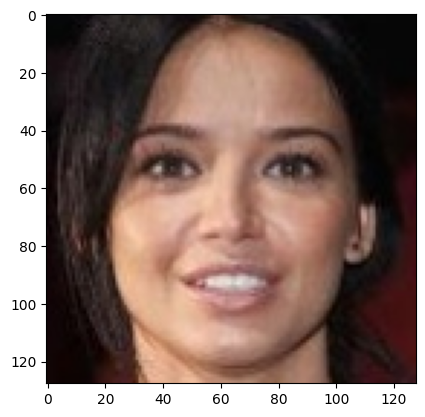

In [ ]:
to_pil_image = transforms.ToPILImage()
plt.imshow(to_pil_image(train_dataset[0]))
plt.show()


In [ ]:
class SRCNN(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64,32,kernel_size=3,padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(32,3,kernel_size=5,padding=2)
        self.dropout = nn.Dropout(p=0.4)
    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu1(x1)
        x2 = self.conv2(x1)
        x2 = self.bn2(x2)
        x2 = self.relu2(x2)
       # x2= self.dropout(x2)
        out = self.conv3(x2)
        return x + out


In [ ]:
model = SRCNN(3).to(device)
#model = torch.compile(model, mode="reduce-overhead")
optimizer = optim.Adam(model.parameters(),lr=0.0005)
num_epochs = 3
criterion = nn.MSELoss()

In [ ]:
def visualize_images(original, upsampled, output):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(original.cpu().permute(1, 2, 0).numpy())
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(upsampled.cpu().permute(1, 2, 0).numpy())
    plt.title('Upsampled Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(output.cpu().permute(1, 2, 0).numpy())
    plt.title('Model Output')
    plt.axis('off')

    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05913373..1.0337583].


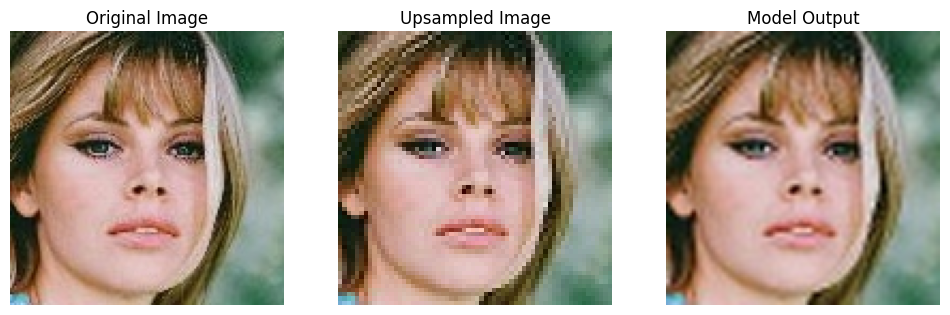

[1/3] Train: 0.0007 | Val: 0.0006 | SSIM: 0.9482


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.030687038..1.0271639].


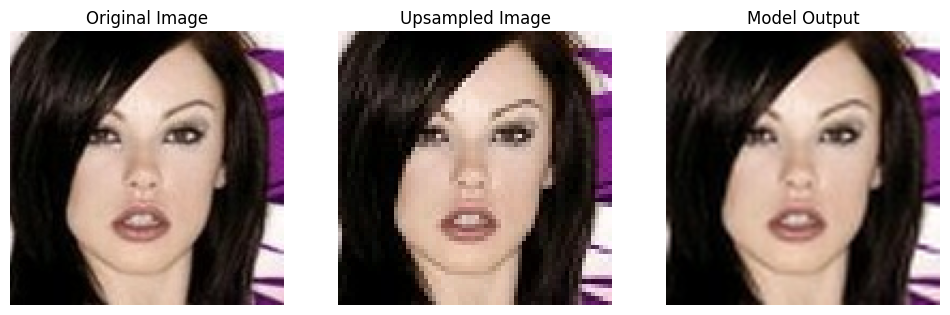

[2/3] Train: 0.0006 | Val: 0.0006 | SSIM: 0.9485


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.014016544..1.0077857].


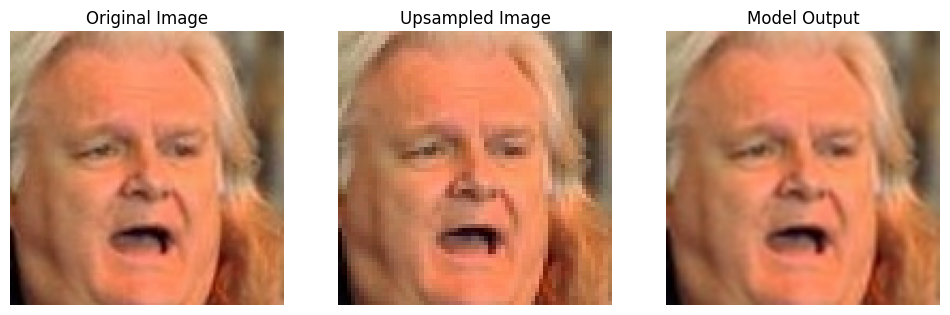

[3/3] Train: 0.0006 | Val: 0.0006 | SSIM: 0.9489


In [ ]:
torch.set_float32_matmul_precision("high")
scaler = torch.amp.GradScaler("cuda")

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0

    for  target_images in train_dataloader:
        optimizer.zero_grad(set_to_none=True)

        hr = target_images.to(device, non_blocking=True)
        lr = make_lr(hr)

        with torch.autocast("cuda", torch.float16):
            sr = model(lr)
            sr = F.interpolate(sr, size=hr.shape[-2:], mode="bicubic", align_corners=False)
            loss = criterion(sr, hr)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()

    model.eval()
    total_val_loss, total_ssim = 0.0, 0.0

    with torch.no_grad():
        for i, ( target_images) in enumerate(val_dataloader):
            hr = target_images.to(device,non_blocking=True)
            lr = make_lr(hr)

            sr = model(lr)
            sr = F.interpolate(sr, size=hr.shape[-2:], mode="bicubic", align_corners=False)

            sr = sr.clamp(0, 1)
            hr = hr.clamp(0, 1)

            loss = criterion(sr, hr)
            ssim_value = ssim(sr, hr, data_range=1.0)

            total_val_loss += loss.item()
            total_ssim += ssim_value.item()

            if i == 0:
                visualize_images(hr[0], lr[0], sr[0])

    print(
        f"[{epoch+1}/{num_epochs}] "
        f"Train: {total_train_loss/len(train_dataloader):.4f} | "
        f"Val: {total_val_loss/len(val_dataloader):.4f} | "
        f"SSIM: {total_ssim/len(val_dataloader):.4f}"
    )


In [ ]:
def calculate_metrics(sr, hr, data_range=1.0):
    mse = F.mse_loss(sr, hr)

    psnr = 10 * torch.log10((data_range ** 2) / mse)

    ssim = ssim_fn(sr, hr, data_range=data_range)

    return ssim.item(), psnr.item(), mse.item()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.038698684..1.0314338].


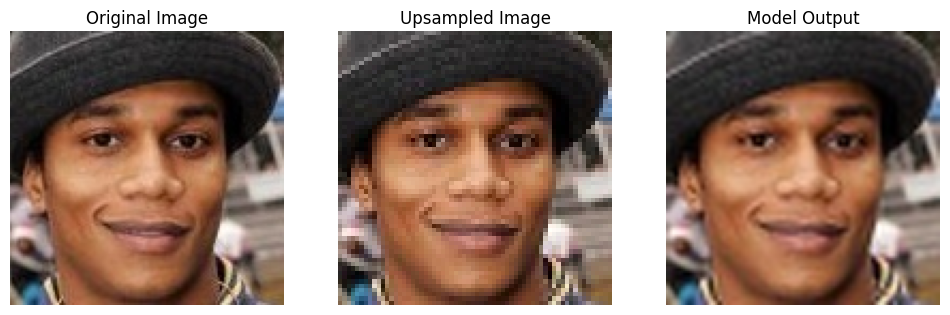

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0533318..1.0424365].


mse loss : 0.0006710570305585861 psnr : 31.732406616210938 ssim :0.9339264631271362


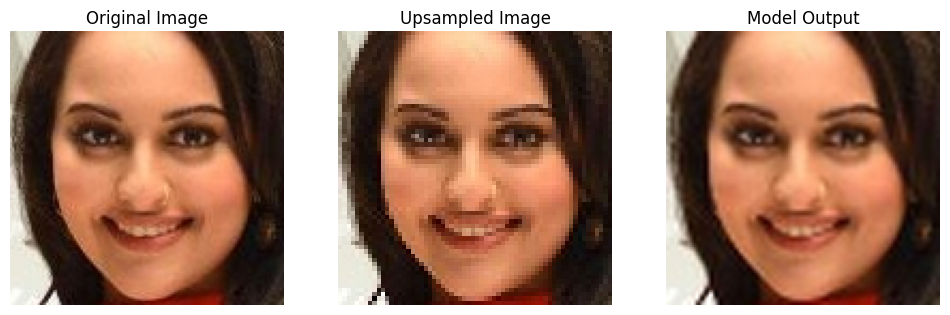

mse loss : 0.0012064746115356684 psnr : 64.44548034667969 ssim :1.8786615133285522


In [ ]:

model.eval()
ssim_total, psnr_total, mse_total = 0.0, 0.0, 0.0

selected_indices = random.sample(
    range(len(val_dataloader.dataset)), k=2
)

with torch.no_grad():
    for idx in selected_indices:
        hr = val_dataloader.dataset[idx]
        hr = hr.unsqueeze(0).to(device)

        lr = F.interpolate(
            hr,
            scale_factor=scale_factor,
            mode="bicubic",
            align_corners=False
        )

        sr = model(lr)

        sr = F.interpolate(
            sr,
            size=hr.shape[-2:],
            mode="bicubic",
            align_corners=False
        )

        sr = sr.clamp(0, 1)
        hr = hr.clamp(0, 1)

        ssim_val, psnr_val, mse_val = calculate_metrics(sr, hr)

        ssim_total += ssim_val
        psnr_total += psnr_val
        mse_total += mse_val

        visualize_images(hr[0], lr[0], sr[0])
        print("mse loss : "+str(mse_total)+" psnr : "+str(psnr_total)+" ssim :"+str(ssim_total))


In [ ]:
save_path = f'/kaggle/working/CELEBA2.pth'

torch.save(model.state_dict(), save_path)